# Exploratory Data Analysis

Using the recently completed runs from wandb to generate insights and figures for upcoming journal publication

In [1]:
import os
os.getcwd()

import wandb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

In [2]:
import pandas as pd
import wandb
from dotenv import load_dotenv
load_dotenv()
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("andberg9-self/Unbearable-Weight-Results")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [3]:
display(len(runs_df))
display(runs_df.head())



70

,summary,config,name
0,"{'_runtime': 625.574689811, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-0augs
1,"{'_runtime': 1958.920681965, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-3augs
2,"{'_runtime': 694.711207529, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-0augs
3,"{'_runtime': 1774.837933873, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-3augs
4,"{'_runtime': 832.59192502, '_step': 308, '_tim...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-ssf-0augs


In [4]:
# model_type = runs_df['config']['model_type']
model_type = runs_df['config'][0]['model_type']
display(model_type)
summarys = runs_df['summary']
# display(summarys[0])
final_average_val_acc = summarys[0]['final_average_val_acc']
display(final_average_val_acc)

final_average_val_std = summarys[0]['final_std_val_acc']
display(final_average_val_std)


'resnet18'

0.956129002571106

0.012172887489089464

In [5]:
# simply DataFrame w/ model_name 
import re
name_list = []
for i in range(0, len(runs_df)):
    name = runs_df['name'][i]
    model_name = re.search(r'\w+', name)
    if model_name.group(0) not in name_list:
        name_list.append(model_name.group(0))
        runs_df['model_name'] = model_name.group(0)
display(runs_df.head())


,summary,config,name,model_name
0,"{'_runtime': 625.574689811, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-0augs,vit_base
1,"{'_runtime': 1958.920681965, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-3augs,vit_base
2,"{'_runtime': 694.711207529, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-0augs,vit_base
3,"{'_runtime': 1774.837933873, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-3augs,vit_base
4,"{'_runtime': 832.59192502, '_step': 308, '_tim...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-ssf-0augs,vit_base


In [6]:
# Extract data for violin plot
import ast
import re

# Create lists to store the data
model_names = []
accuracies = []
std_devs = []
config_types = []
aug_levels = []

for i in range(len(runs_df)):
    # Get the summary data
    summary = runs_df['summary'][i]
    name = runs_df['name'][i]
    config = runs_df['config'][i]
    
    # Extract accuracy and std dev
    if 'final_average_val_acc' in summary:
        accuracy = summary['final_average_val_acc']
        std_dev = summary['final_std_val_acc']
        
        # Extract model type from config
        model_type = config['model_type']
        
        # Extract configuration type and augmentation level from name
        # Parse name like "resnet18-full-0augs" or "vit-ssf-3augs"
        name_parts = name.split('-')
        print(name_parts)
        if len(name_parts) >= 3:
            config_type = name_parts[1]  # full, classifier, ssf, etc.
            aug_level = config['augmentation_config']['augmentations_per_sample']     # 0augs, 3augs, etc.
            # aug_level = re.findall(r'\d+', aug_part)[0] if re.findall(r'\d+', aug_part) else '0'
        else:
            config_type = 'unknown'
            aug_level = '0'
        
        model_names.append(model_type)
        accuracies.append(accuracy)
        std_devs.append(std_dev)
        config_types.append(config_type)
        aug_levels.append(aug_level)

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    'model': model_names,
    'accuracy': accuracies,
    'std_dev': std_devs,
    'config_type': config_types,
    'aug_level': aug_levels,
    'model_config': [f"{m}-{c}" for m, c in zip(model_names, config_types)]
})

print(f"Total runs: {len(plot_df)}")
print(f"Unique models: {plot_df['model'].unique()}")
print(f"Unique config types: {plot_df['config_type'].unique()}")
print(f"Unique augmentation levels: {plot_df['aug_level'].unique()}")
display(plot_df.head())


['resnet18', 'full', '0augs']
['resnet18', 'full', '3augs']
['resnet18', 'classifier', '0augs']
['resnet18', 'classifier', '3augs']
['resnet18', 'ssf', '0augs']
['resnet18', 'ssf', '3augs']
['resnet18', 'batchnorm', '0augs']
['resnet18', 'batchnorm', '3augs']
['resnet152', 'full', '0augs']
['resnet152', 'full', '3augs']
['resnet152', 'classifier', '0augs']
['resnet152', 'classifier', '3augs']
['resnet152', 'ssf', '0augs']
['resnet152', 'ssf', '3augs']
['resnet152', 'batchnorm', '0augs']
['resnet152', 'batchnorm', '3augs']
['mobilenet_v3_small', 'full', '0augs']
['mobilenet_v3_small', 'full', '3augs']
['mobilenet_v3_small', 'classifier', '0augs']
['mobilenet_v3_small', 'classifier', '3augs']
['mobilenet_v3_small', 'ssf', '0augs']
['mobilenet_v3_small', 'ssf', '3augs']
['mobilenet_v3_small', 'batchnorm', '0augs']
['mobilenet_v3_small', 'batchnorm', '3augs']
['mobilenet_v3_large', 'full', '0augs']
['mobilenet_v3_large', 'full', '3augs']
['mobilenet_v3_large', 'classifier', '0augs']
['mobi

,model,accuracy,std_dev,config_type,aug_level,model_config
0,resnet18,0.956129,0.012173,full,0,resnet18-full
1,resnet18,0.969677,0.006797,full,3,resnet18-full
2,resnet18,0.861290,0.023440,classifier,0,resnet18-classifier
3,resnet18,0.863871,0.020821,classifier,3,resnet18-classifier
4,resnet18,0.916774,0.014412,ssf,0,resnet18-ssf


In [7]:
len(plot_df)

70

In [8]:
import datetime
# Extract _runtime for each run and add as a new column to plot_df
plot_df['runtime'] = [runs_df['summary'][i]['_runtime'] for i in range(len(runs_df))]
# add a convert hhmmss to seconds column
plot_df['runtime_hhmmss'] = plot_df['runtime'].apply(lambda x: datetime.timedelta(seconds=x))
total_seconds = plot_df['runtime'].sum()
total_runtime = datetime.timedelta(seconds=total_seconds)
len(plot_df)



70

In [9]:
plot_df['total_parameters'] = [runs_df['summary'][i]['model/total_parameters'] for i in range(len(runs_df))]
plot_df['trainable_parameters'] = [runs_df['summary'][i]['model/trainable_parameters'] for i in range(len(runs_df))]
plot_df['trainable_percentage'] = [runs_df['summary'][i]['model/trainable_percentage'] for i in range(len(runs_df))]
plot_df['trainable_parameters'] = [runs_df['summary'][i]['model/total_parameters'] for i in range(len(runs_df))]
plot_df['memory_footprint_mb'] = [runs_df['summary'][i]['model/memory_footprint_mb'] for i in range(len(runs_df))]
len(plot_df)

70

In [10]:
# remove outliers from std_dev and accuracy
# plot_df = plot_df[plot_df['std_dev'] < 0.1]
# plot_df = plot_df[plot_df['accuracy'] > 0.5]


In [11]:
# Helper functions for plotting
def get_ordered_categories(df, group_col, value_col):
    """Get ordered categories by mean value (descending)"""
    order = (
        df.groupby(group_col)[value_col]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    return order

def add_min_max_annotations(ax, df, x_col, y_col, order):
    """Add min/max annotations to violin plots"""
    for i, category in enumerate(order):
        category_data = df[df[x_col] == category][y_col]
        if len(category_data) > 0:
            min_val = category_data.min()
            max_val = category_data.max()
            
            # Add min annotation (red triangle pointing down)
            ax.scatter(i, min_val, color='red', marker='v', s=50, zorder=10)
            ax.annotate(f'{min_val:.3f}', (i, min_val), 
                       xytext=(5, -15), textcoords='offset points',
                       fontsize=8, color='red', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
            
            # Add max annotation (green triangle pointing up)
            ax.scatter(i, max_val, color='green', marker='^', s=50, zorder=10)
            ax.annotate(f'{max_val:.3f}', (i, max_val), 
                       xytext=(5, 10), textcoords='offset points',
                       fontsize=8, color='green', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))


C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\2235499162.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax1, palette='Set2', order=model_order, cut=0.2, inner="quartile")
C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\2235499162.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax2, palette='Set1', order=config_order, cut=0.2, inner="quartile")
C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\2235499162.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

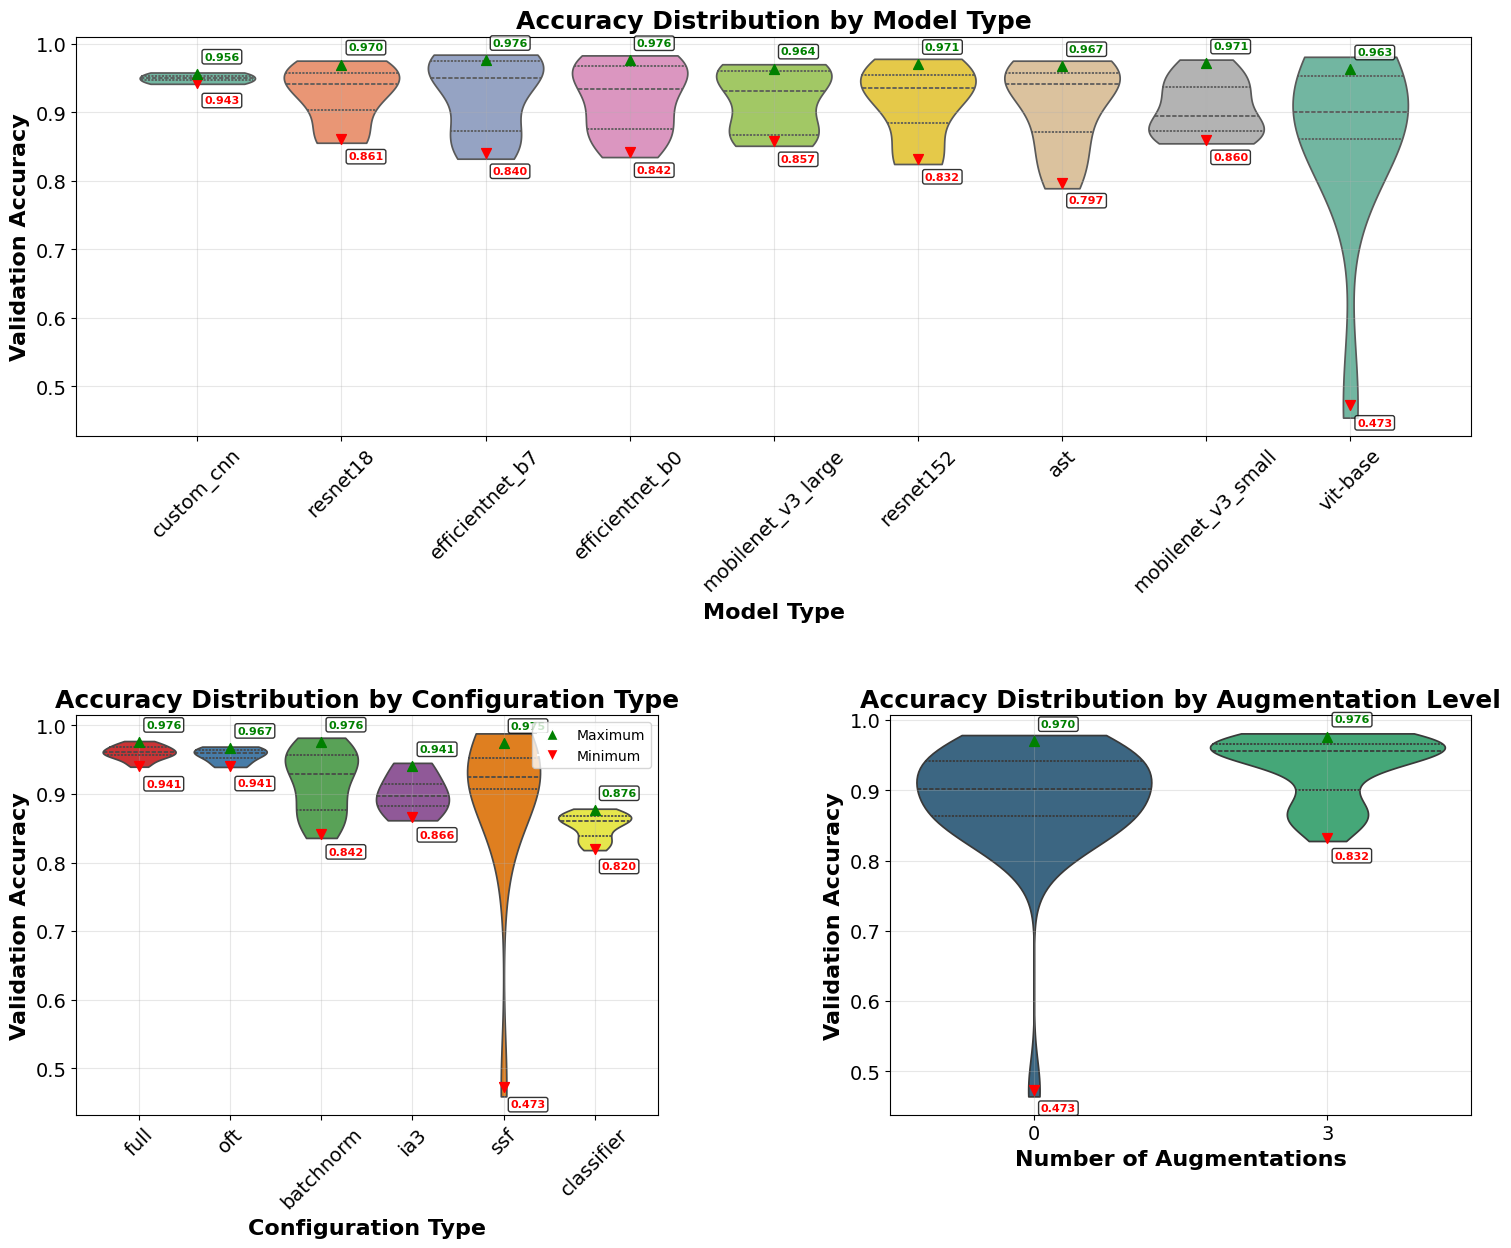

70

In [12]:
# Combined Accuracy Analysis: Three plots in subplot layout
plt.style.use('default')
fig = plt.figure(figsize=(18, 14))  # Increased figure size for better readability

# Create subplot layout: top plot spans full width, bottom two plots side by side
# Increase hspace for more vertical space between upper and lower subplots
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.7, wspace=0.4)

# Top subplot: Accuracy distribution by model type (spans both columns)
ax1 = fig.add_subplot(gs[0, :])  # Spans both columns
model_order = get_ordered_categories(plot_df, 'model', 'accuracy')
sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax1, palette='Set2', order=model_order, cut=0.2, inner="quartile")
add_min_max_annotations(ax1, plot_df, 'model', 'accuracy', model_order)

ax1.set_title('Accuracy Distribution by Model Type', fontsize=18, weight='bold')
ax1.set_xlabel('Model Type', fontsize=16, weight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=16, weight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(True, alpha=0.3)

# Bottom left subplot: Accuracy distribution by configuration type
ax2 = fig.add_subplot(gs[1, 0])
config_order = get_ordered_categories(plot_df, 'config_type', 'accuracy')
sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax2, palette='Set1', order=config_order, cut=0.2, inner="quartile")
add_min_max_annotations(ax2, plot_df, 'config_type', 'accuracy', config_order)

ax2.set_title('Accuracy Distribution by Configuration Type', fontsize=18, weight='bold')
ax2.set_xlabel('Configuration Type', fontsize=16, weight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=16, weight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(True, alpha=0.3)

# Add legend for min/max markers on bottom left
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax2.legend(handles=legend_elements, loc='upper right')

# Bottom right subplot: Accuracy vs augmentation level
ax3 = fig.add_subplot(gs[1, 1])
# For aug_level, ensure it's sorted by mean accuracy, but keep as string for x-axis
aug_order = get_ordered_categories(plot_df, 'aug_level', 'accuracy')
sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax3, palette='viridis', order=aug_order.reverse(), cut=0.2, inner="quartile")
add_min_max_annotations(ax3, plot_df, 'aug_level', 'accuracy', aug_order)

ax3.set_title('Accuracy Distribution by Augmentation Level', fontsize=18, weight='bold')
ax3.set_xlabel('Number of Augmentations', fontsize=16, weight='bold')
ax3.set_ylabel('Validation Accuracy', fontsize=16, weight='bold')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_analysis_combined.png', dpi=300, bbox_inches='tight')
plt.show()

len(plot_df)

C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\262552576.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order, cut=0.2, inner="quartile")


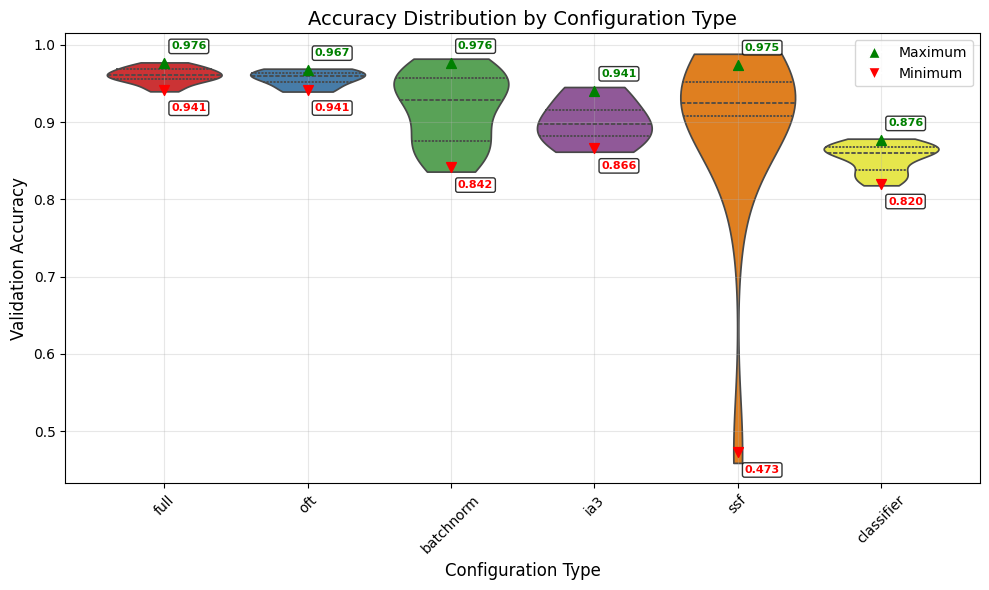

C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\262552576.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order.reverse(), cut=0.2, inner="quartile")


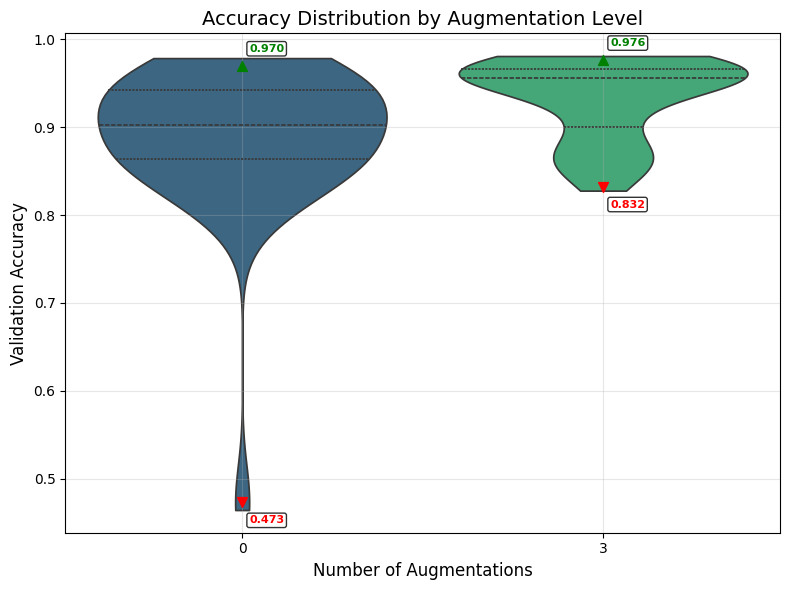

In [13]:
# Plot 2: Accuracy distribution by configuration type (ordered)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

config_order = get_ordered_categories(plot_df, 'config_type', 'accuracy')
sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order, cut=0.2, inner="quartile")
add_min_max_annotations(ax, plot_df, 'config_type', 'accuracy', config_order)

ax.set_title('Accuracy Distribution by Configuration Type', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('accuracy_by_config_type.png', dpi=300, bbox_inches='tight')
plt.show()
# Plot 4: Accuracy vs augmentation level (ordered)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# For aug_level, ensure it's sorted by mean accuracy, but keep as string for x-axis
aug_order = get_ordered_categories(plot_df, 'aug_level', 'accuracy')
sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order.reverse(), cut=0.2, inner="quartile")
add_min_max_annotations(ax, plot_df, 'aug_level', 'accuracy', aug_order)

ax.set_title('Accuracy Distribution by Augmentation Level', fontsize=14)
ax.set_xlabel('Number of Augmentations', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
# legend_elements = [
#     plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
#     plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
# ]
# ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('accuracy_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\1258208590.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([], [], c=plt.cm.tab10(i), label=model, s=80)


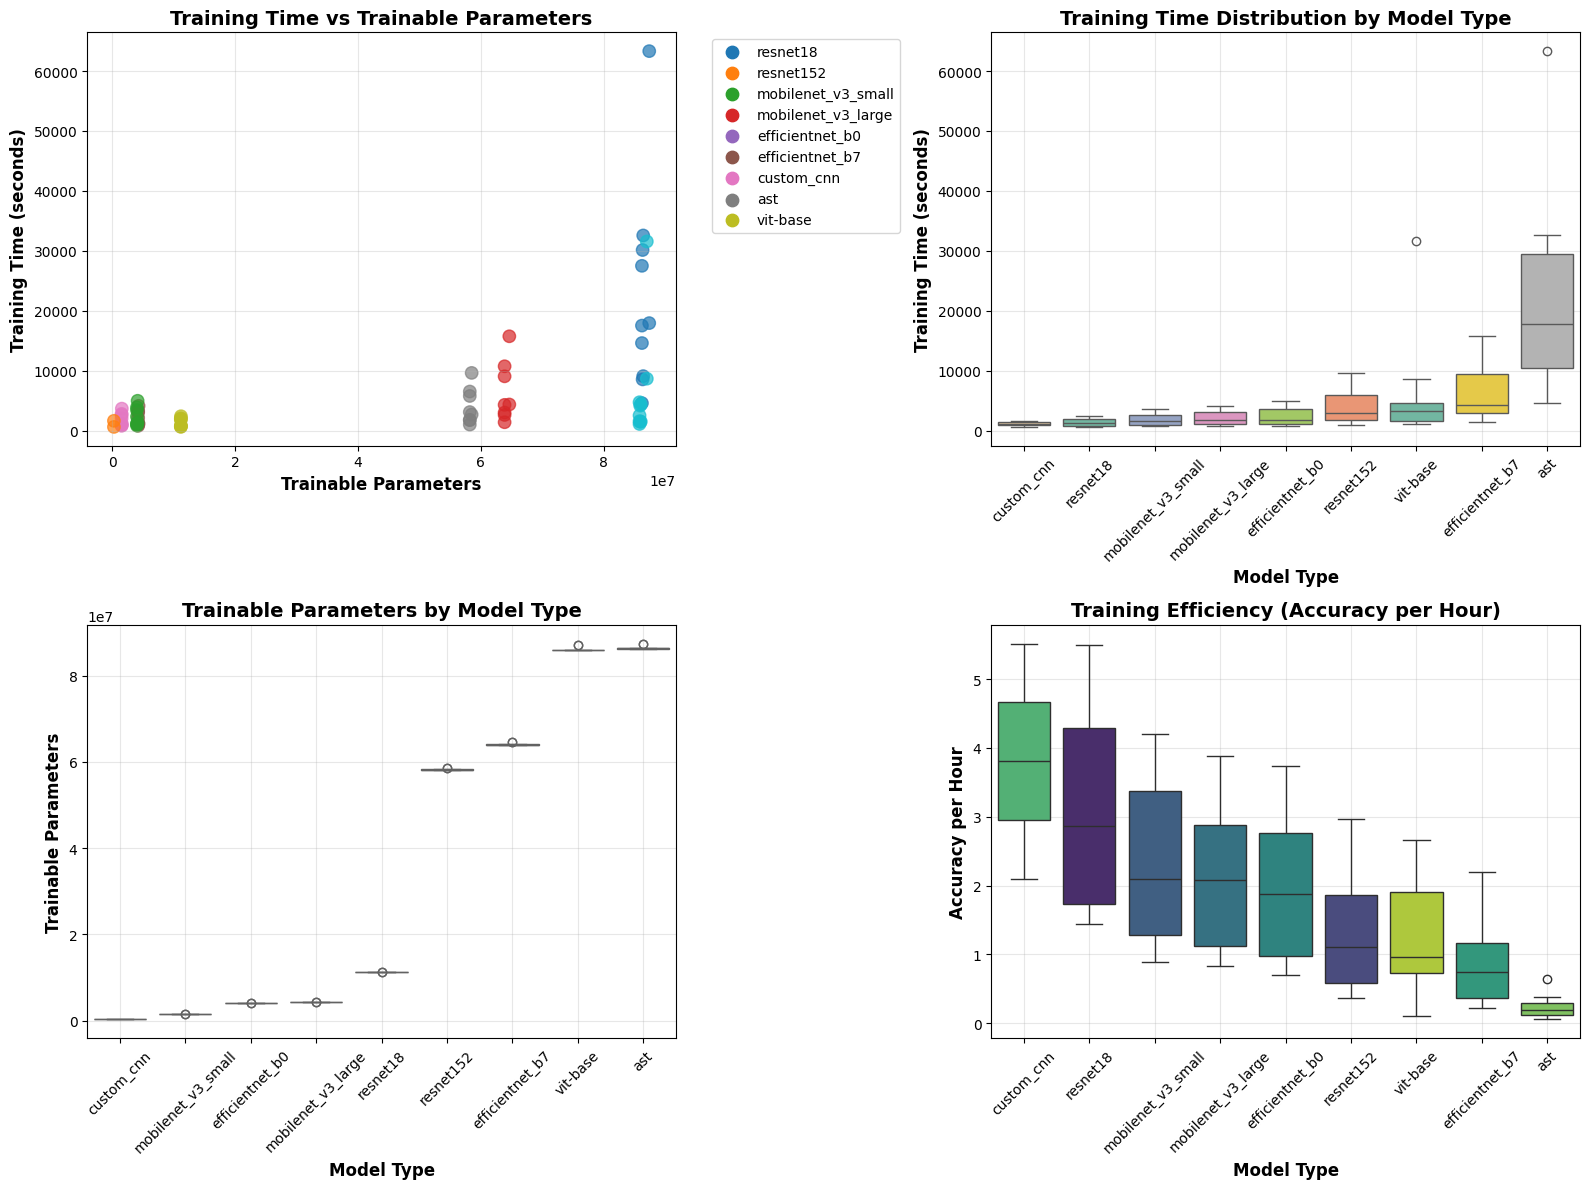


Summary Statistics:
                       runtime                                     \
                          mean         std        min         max   
model                                                               
ast                 22582.9022  17171.1872  4589.0200  63320.3135   
custom_cnn           1126.4578    722.4690   615.5951   1637.3205   
efficientnet_b0      2383.7893   1545.3489   843.9773   4982.0238   
efficientnet_b7      6404.9928   4964.5217  1399.4991  15742.2811   
mobilenet_v3_large   2108.2467   1243.1923   804.6125   4131.1378   
mobilenet_v3_small   1867.7706   1076.4183   815.5148   3672.3872   
resnet152            4034.7834   2992.7218  1007.4145   9632.7834   
resnet18             1394.2458    728.0977   625.5747   2407.0709   
vit-base             6169.5796   9214.0881  1108.5407  31562.2862   

                   trainable_parameters                                   \
                                   mean          std       min       max  

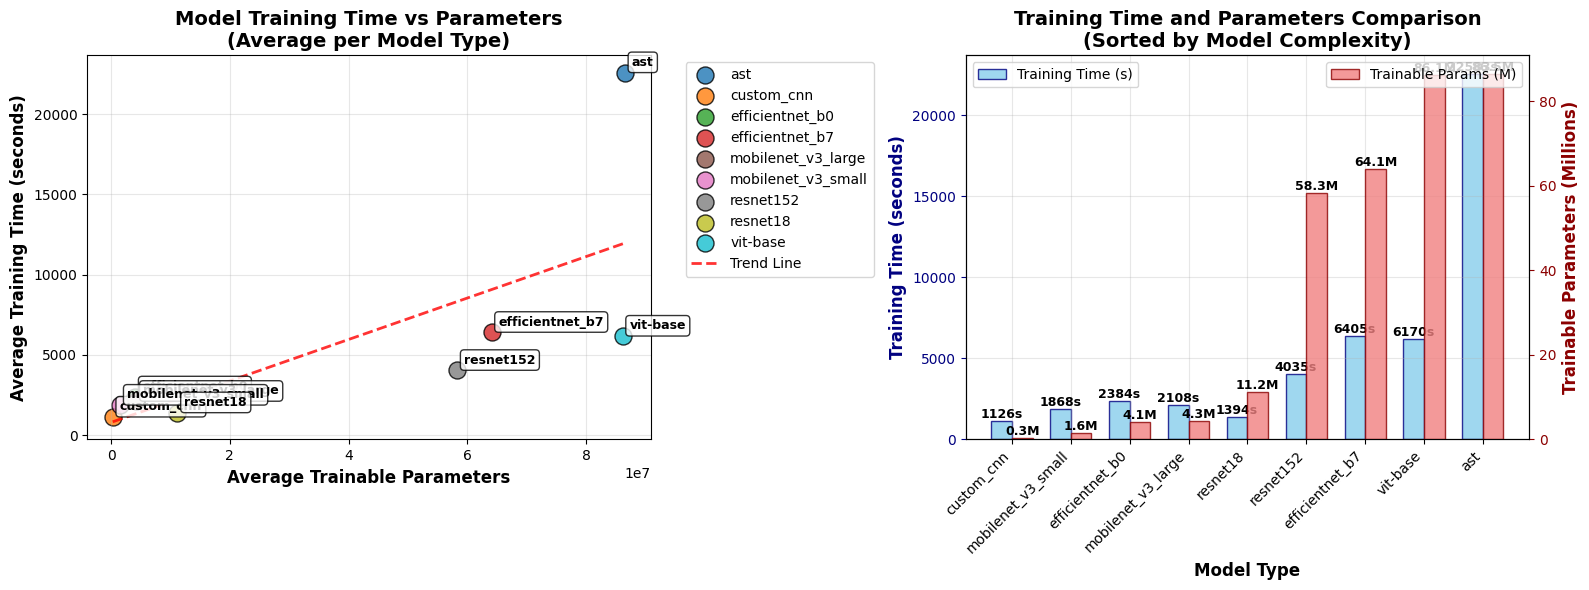


Detailed Model Comparison Table:
                   runtime_mean trainable_parameters_mean accuracy_mean  \
model                                                                     
custom_cnn                1126s                     0.29M         0.950   
resnet18                  1394s                    11.19M         0.926   
mobilenet_v3_small        1868s                     1.56M         0.906   
mobilenet_v3_large        2108s                     4.26M         0.917   
efficientnet_b0           2384s                     4.07M         0.921   
resnet152                 4035s                    58.28M         0.916   
vit-base                  6170s                    86.12M         0.864   
efficientnet_b7           6405s                    64.06M         0.925   
ast                      22583s                    86.51M         0.910   

                    memory_footprint_mb_mean  
model                                         
custom_cnn                             1.121  

In [14]:
# Print summary statistics
print("=== SUMMARY STATISTICS ===")
print("\nAccuracy by Model Type:")
print(plot_df.groupby('model')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nAccuracy by Configuration Type:")
print(plot_df.groupby('config_type')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nStandard Deviation by Configuration Type:")
print(plot_df.groupby('config_type')['std_dev'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nAccuracy by Augmentation Level:")
print(plot_df.groupby('aug_level')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))


=== SUMMARY STATISTICS ===

Accuracy by Model Type:
                      mean     std     min     max
model                                             
ast                 0.9105  0.0627  0.7971  0.9674
custom_cnn          0.9498  0.0094  0.9432  0.9565
efficientnet_b0     0.9212  0.0524  0.8416  0.9761
efficientnet_b7     0.9250  0.0582  0.8400  0.9765
mobilenet_v3_large  0.9175  0.0475  0.8574  0.9639
mobilenet_v3_small  0.9058  0.0425  0.8603  0.9713
resnet152           0.9156  0.0557  0.8319  0.9706
resnet18            0.9262  0.0432  0.8613  0.9697
vit-base            0.8642  0.1458  0.4729  0.9626

Accuracy by Configuration Type:
               mean     std     min     max
config_type                                
batchnorm    0.9179  0.0464  0.8416  0.9765
classifier   0.8542  0.0185  0.8203  0.8765
full         0.9607  0.0101  0.9410  0.9761
ia3          0.9005  0.0314  0.8665  0.9406
oft          0.9569  0.0114  0.9413  0.9674
ssf          0.8958  0.1211  0.4729  0.9745

S

In [15]:
# Runtime Analysis Setup - Data preparation and helper functions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert runtime to minutes for better readability
plot_df['runtime_minutes'] = plot_df['runtime'] / 60
plot_df['runtime_hours'] = plot_df['runtime'] / 3600

# Helper function to get ordered categories by mean runtime (ascending - fastest first)
def get_ordered_categories_runtime(df, group_col, value_col):
    order = (
        df.groupby(group_col)[value_col]
        .mean()
        .sort_values(ascending=True)  # Ascending for runtime (fastest first)
        .index
        .tolist()
    )
    return order

# Helper function to add runtime statistics annotations
def add_runtime_stats(ax, df, x_col, y_col, order):
    for i, category in enumerate(order):
        category_data = df[df[x_col] == category][y_col]
        if len(category_data) > 0:
            mean_val = category_data.mean()
            median_val = category_data.median()
            
            # Add mean annotation (blue diamond)
            ax.scatter(i, mean_val, color='blue', marker='D', s=60, zorder=10, alpha=0.8)
            ax.annotate(f'μ:{mean_val:.1f}m', (i, mean_val), 
                       xytext=(5, 15), textcoords='offset points',
                       fontsize=9, color='blue', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
            
            # Add median annotation (orange square)
            ax.scatter(i, median_val, color='orange', marker='s', s=50, zorder=10, alpha=0.8)
            ax.annotate(f'M:{median_val:.1f}m', (i, median_val), 
                       xytext=(5, -20), textcoords='offset points',
                       fontsize=9, color='orange', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', alpha=0.7))


=== RUNTIME PERFORMANCE STATISTICS ===

C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\1879756112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(



Total runtime across all experiments: 5 days, 0:55:28.362073
Total runtime in hours: 120.92 hours
Average runtime per experiment: 103.65 minutes
Median runtime per experiment: 43.51 minutes

=== RUNTIME BY MODEL TYPE ===
                      mean  median     std    min      max  count
model                                                            
custom_cnn           18.77   18.77   12.04  10.26    27.29      2
resnet18             23.24   21.73   12.13  10.43    40.12      8
mobilenet_v3_small   31.13   26.96   17.94  13.59    61.21      8
mobilenet_v3_large   35.14   28.47   20.72  13.41    68.85      8
efficientnet_b0      39.73   30.83   25.76  14.07    83.03      8
resnet152            67.25   48.23   49.88  16.79   160.55      8
vit-base            102.83   55.91  153.57  18.48   526.04     10
efficientnet_b7     106.75   72.19   82.74  23.32   262.37      8
ast                 376.38  295.56  286.19  76.48  1055.34     10

=== RUNTIME BY CONFIGURATION TYPE ===
             

C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\1879756112.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


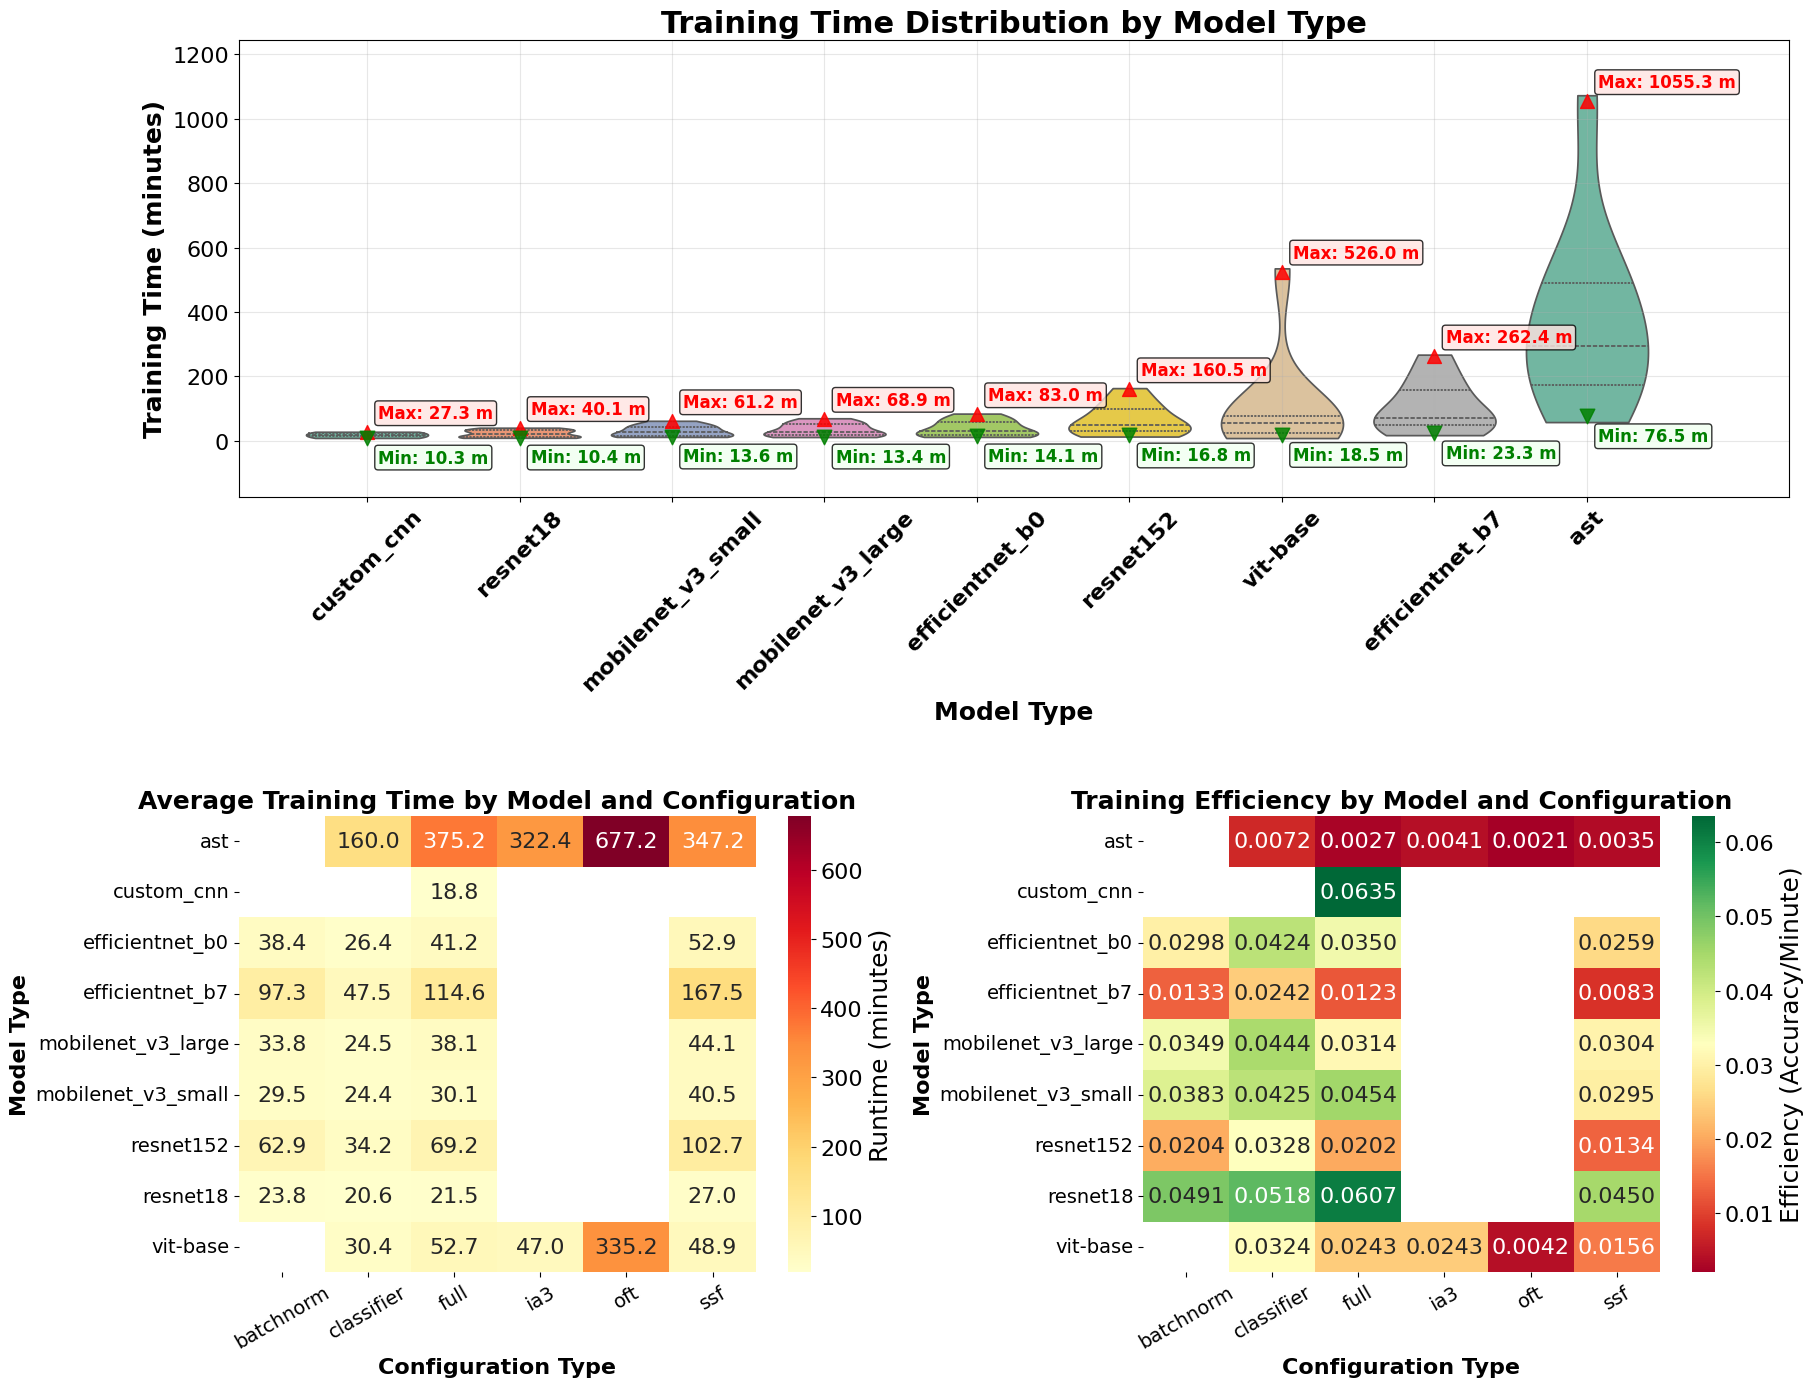

In [16]:
# Combined Runtime Analysis: Three plots in subplot layout
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))  # Increased figure size for better readability

# Create subplot layout: top plot spans full width, bottom two plots side by side
# Increase hspace for more vertical space between upper and lower subplots
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.7, wspace=0.4)

# Top subplot: Training time distribution by model type
ax1 = fig.add_subplot(gs[0, :])  # Spans both columns
model_order_runtime = get_ordered_categories_runtime(plot_df, 'model', 'runtime_minutes')
sns.violinplot(
    data=plot_df,
    x='model',
    y='runtime_minutes',
    ax=ax1,
    palette='Set2',
    order=model_order_runtime,
    cut=0.1,
    inner="quartile"
)

# Improved annotation function: use red for max, green for min, use triangles for symbols
def add_runtime_stats_max_min(ax, df, x_col, y_col, order):
    for i, category in enumerate(order):
        category_data = df[df[x_col] == category][y_col]
        if len(category_data) > 0:
            max_val = category_data.max()
            min_val = category_data.min()
            
            # Add max annotation (red upward triangle)
            ax.scatter(i, max_val, color='red', marker='^', s=100, zorder=10, alpha=0.85)
            ax.annotate(
                f'Max: {max_val:.1f} m', (i, max_val),
                xytext=(8, 10), textcoords='offset points',
                fontsize=12, color='red', weight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='mistyrose', alpha=0.8)
            )
            
            # Add min annotation (green downward triangle)
            ax.scatter(i, min_val, color='green', marker='v', s=110, zorder=10, alpha=0.85)
            ax.annotate(
                f'Min: {min_val:.1f} m', (i, min_val),
                xytext=(8, -18), textcoords='offset points',
                fontsize=12, color='green', weight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='honeydew', alpha=0.8)
            )

add_runtime_stats_max_min(ax1, plot_df, 'model', 'runtime_minutes', model_order_runtime)

ax1.set_title('Training Time Distribution by Model Type', fontsize=22, weight='bold')
ax1.set_xlabel('Model Type', fontsize=18, weight='bold')
ax1.set_ylabel('Training Time (minutes)', fontsize=18, weight='bold')
ax1.tick_params(axis='x', labelsize=16, rotation=45)
ax1.tick_params(axis='y', labelsize=16)
ax1.grid(True, alpha=0.3)

# --- Extend the x-axis and y-axis slightly beyond their current limits without changing the ticks ---
# Get current x and y limits
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

# Extend x-axis slightly to the right (e.g., by 5% of the range)
x_extra = 0.05 * (xmax - xmin)
ax1.set_xlim(left=xmin, right=xmax + x_extra)

# Extend y-axis slightly upward (e.g., by 10% of the range)
y_extra = 0.10 * (ymax - ymin)
ax1.set_ylim(bottom=ymin, top=ymax + y_extra)

# Increase font size for x-axis labels (model names)
for label in ax1.get_xticklabels():
    label.set_fontsize(16)
    label.set_weight('bold')

# --- Extend the y-axis below zero for the bottom graph (ax1) for better visual ---
# Get current y-limits
ymin, ymax = ax1.get_ylim()
# Extend the lower limit a bit further below zero (e.g., 10% of the range or at least -5)
extra = max(0.1 * (ymax - ymin), 5)
ax1.set_ylim(bottom=min(0, ymin - extra))

# Detailed Runtime Statistics and Efficiency Analysis
print("=== RUNTIME PERFORMANCE STATISTICS ===")
print(f"Total runtime across all experiments: {total_runtime}")
print(f"Total runtime in hours: {total_seconds/3600:.2f} hours")
print(f"Average runtime per experiment: {plot_df['runtime_minutes'].mean():.2f} minutes")
print(f"Median runtime per experiment: {plot_df['runtime_minutes'].median():.2f} minutes")

print("\n=== RUNTIME BY MODEL TYPE ===")
runtime_by_model = plot_df.groupby('model')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_model = runtime_by_model.sort_values('mean')  # Sort by mean runtime (fastest first)
print(runtime_by_model)

print("\n=== RUNTIME BY CONFIGURATION TYPE ===")
runtime_by_config = plot_df.groupby('config_type')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_config = runtime_by_config.sort_values('mean')
print(runtime_by_config)

print("\n=== RUNTIME BY AUGMENTATION LEVEL ===")
runtime_by_aug = plot_df.groupby('aug_level')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_aug = runtime_by_aug.sort_values('mean')
print(runtime_by_aug)

print("\n=== EFFICIENCY METRICS (Accuracy per Minute) ===")
plot_df['efficiency'] = plot_df['accuracy'] / plot_df['runtime_minutes']
efficiency_by_model = plot_df.groupby('model')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_model = efficiency_by_model.sort_values('mean', ascending=False)  # Sort by efficiency (best first)
print("Efficiency by Model Type (Accuracy/Minute):")
print(efficiency_by_model)

efficiency_by_config = plot_df.groupby('config_type')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_config = efficiency_by_config.sort_values('mean', ascending=False)
print("\nEfficiency by Configuration Type (Accuracy/Minute):")
print(efficiency_by_config)

# Find the most efficient runs
print("\n=== TOP 10 MOST EFFICIENT RUNS ===")
top_efficient = plot_df.nlargest(10, 'efficiency')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(top_efficient.round(4))

# Find the fastest runs
print("\n=== TOP 10 FASTEST RUNS ===")
fastest_runs = plot_df.nsmallest(10, 'runtime_minutes')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(fastest_runs.round(4))

# Advanced Runtime Analysis Setup - Create pivot tables for heatmaps
runtime_pivot = plot_df.pivot_table(values='runtime_minutes', index='model', columns='config_type', aggfunc='mean')
accuracy_pivot = plot_df.pivot_table(values='accuracy', index='model', columns='config_type', aggfunc='mean')
efficiency_pivot = plot_df.pivot_table(values='efficiency', index='model', columns='config_type', aggfunc='mean')

print("Pivot tables created for advanced runtime analysis")

# Bottom left subplot: Runtime heatmap by model and configuration type
ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(
    runtime_pivot,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    ax=ax2,
    cbar_kws={'label': 'Runtime (minutes)'},
    annot_kws={"size": 16},  # Increased font size for floats
)
ax2.set_title('Average Training Time by Model and Configuration', fontsize=18, weight='bold')
ax2.set_xlabel('Configuration Type', fontsize=16, weight='bold')
ax2.set_ylabel('Model Type', fontsize=16, weight='bold')
ax2.tick_params(axis='x', labelsize=14, rotation=30)
ax2.tick_params(axis='y', labelsize=14) 

# Make the colorbar label for runtime (minutes) larger font
cbar = ax2.collections[0].colorbar
cbar.set_label('Runtime (minutes)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Bottom right subplot: Efficiency heatmap by model and configuration type
ax3 = fig.add_subplot(gs[1, 1])
sns.heatmap(
    efficiency_pivot,
    annot=True,
    fmt='.4f',
    cmap='RdYlGn',
    ax=ax3,
    cbar_kws={'label': 'Efficiency (Accuracy/Minute)'},
    annot_kws={"size": 16},  # Increased font size for floats
)
ax3.set_title('Training Efficiency by Model and Configuration', fontsize=18, weight='bold')
ax3.set_xlabel('Configuration Type', fontsize=16, weight='bold')
ax3.set_ylabel('Model Type', fontsize=16, weight='bold')
ax3.tick_params(axis='x', labelsize=14, rotation=30)
ax3.tick_params(axis='y', labelsize=14)
# Make the colorbar label for runtime (minutes) larger font
cbar = ax3.collections[0].colorbar
cbar.set_label('Efficiency (Accuracy/Minute)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('runtime_analysis_combined.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\718600129.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


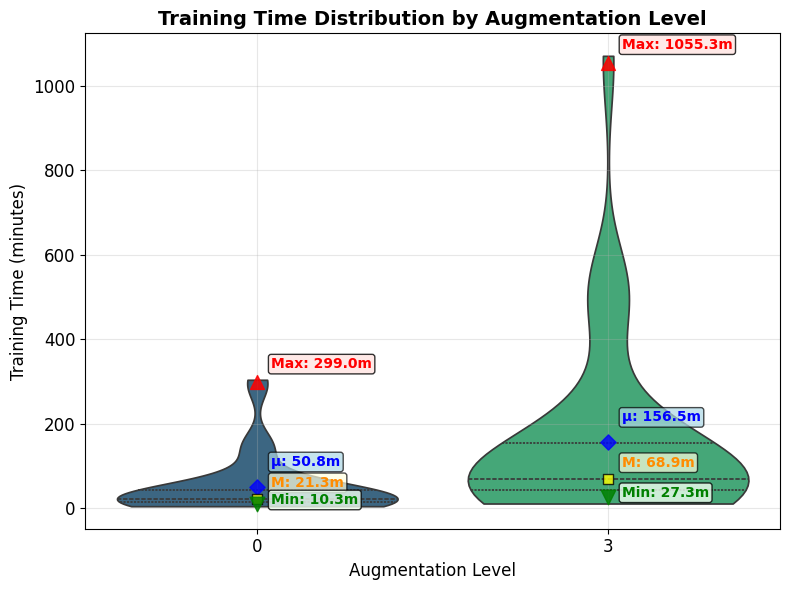

In [17]:
# Plot: Augmentation Level vs. Training Time (runtime_minutes)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get ordered categories by mean runtime (ascending - fastest first)
aug_order_runtime = get_ordered_categories_runtime(plot_df, 'aug_level', 'runtime_minutes')

sns.violinplot(
    data=plot_df,
    x='aug_level',
    y='runtime_minutes',
    ax=ax,
    palette='viridis',
    order=aug_order_runtime,
    cut=0.15,
    inner="quartile"
)

# Add all statistical annotations with improved spacing
for i, category in enumerate(aug_order_runtime):
    category_data = plot_df[plot_df['aug_level'] == category]['runtime_minutes']
    if len(category_data) > 0:
        min_val = category_data.min()
        max_val = category_data.max()
        mean_val = category_data.mean()
        median_val = category_data.median()
        
        # Add max annotation (red upward triangle) - top position
        ax.scatter(i, max_val, color='red', marker='^', s=100, zorder=10, alpha=0.85)
        ax.annotate(
            f'Max: {max_val:.1f}m', (i, max_val),
            xytext=(10, 10), textcoords='offset points',
            fontsize=10, color='red', weight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='mistyrose', alpha=0.8)
        )
        
        # Add mean annotation (blue diamond) - upper middle position
        ax.scatter(i, mean_val, color='blue', marker='D', s=60, zorder=10, alpha=0.8)
        ax.annotate(f'μ: {mean_val:.1f}m', (i, mean_val), 
                   xytext=(10, 15), textcoords='offset points',
                   fontsize=10, color='blue', weight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
        
        # Add median annotation (yellow square) - lower middle position
        ax.scatter(i, median_val, color='yellow', marker='s', s=50, zorder=10, alpha=0.8, edgecolors='black', linewidth=1)
        ax.annotate(f'M: {median_val:.1f}m', (i, median_val), 
                   xytext=(10, 9), textcoords='offset points',
                   fontsize=10, color='darkorange', weight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', alpha=0.7))
        
        # Add min annotation (green downward triangle) - bottom position
        ax.scatter(i, min_val, color='green', marker='v', s=110, zorder=10, alpha=0.85)
        ax.annotate(
            f'Min: {min_val:.1f}m', (i, min_val),
            xytext=(10, 0), textcoords='offset points',
            fontsize=10, color='green', weight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='honeydew', alpha=0.8)
        )

ax.set_title('Training Time Distribution by Augmentation Level', fontsize=14, weight='bold')
ax.set_xlabel('Augmentation Level', fontsize=12)
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('runtime_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Detailed Runtime Statistics and Efficiency Analysis
print("=== RUNTIME PERFORMANCE STATISTICS ===")
print(f"Total runtime across all experiments: {total_runtime}")
print(f"Total runtime in hours: {total_seconds/3600:.2f} hours")
print(f"Average runtime per experiment: {plot_df['runtime_minutes'].mean():.2f} minutes")
print(f"Median runtime per experiment: {plot_df['runtime_minutes'].median():.2f} minutes")

print("\n=== RUNTIME BY MODEL TYPE ===")
runtime_by_model = plot_df.groupby('model')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_model = runtime_by_model.sort_values('mean')  # Sort by mean runtime (fastest first)
print(runtime_by_model)

print("\n=== RUNTIME BY CONFIGURATION TYPE ===")
runtime_by_config = plot_df.groupby('config_type')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_config = runtime_by_config.sort_values('mean')
print(runtime_by_config)

print("\n=== RUNTIME BY AUGMENTATION LEVEL ===")
runtime_by_aug = plot_df.groupby('aug_level')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_aug = runtime_by_aug.sort_values('mean')
print(runtime_by_aug)

print("\n=== EFFICIENCY METRICS (Accuracy per Minute) ===")
plot_df['efficiency'] = plot_df['accuracy'] / plot_df['runtime_minutes']
efficiency_by_model = plot_df.groupby('model')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_model = efficiency_by_model.sort_values('mean', ascending=False)  # Sort by efficiency (best first)
print("Efficiency by Model Type (Accuracy/Minute):")
print(efficiency_by_model)

efficiency_by_config = plot_df.groupby('config_type')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_config = efficiency_by_config.sort_values('mean', ascending=False)
print("\nEfficiency by Configuration Type (Accuracy/Minute):")
print(efficiency_by_config)

# Find the most efficient runs
print("\n=== TOP 10 MOST EFFICIENT RUNS ===")
top_efficient = plot_df.nlargest(10, 'efficiency')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(top_efficient.round(4))

# Find the fastest runs
print("\n=== TOP 10 FASTEST RUNS ===")
fastest_runs = plot_df.nsmallest(10, 'runtime_minutes')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(fastest_runs.round(4))


=== RUNTIME PERFORMANCE STATISTICS ===
Total runtime across all experiments: 5 days, 0:55:28.362073
Total runtime in hours: 120.92 hours
Average runtime per experiment: 103.65 minutes
Median runtime per experiment: 43.51 minutes

=== RUNTIME BY MODEL TYPE ===
                      mean  median     std    min      max  count
model                                                            
custom_cnn           18.77   18.77   12.04  10.26    27.29      2
resnet18             23.24   21.73   12.13  10.43    40.12      8
mobilenet_v3_small   31.13   26.96   17.94  13.59    61.21      8
mobilenet_v3_large   35.14   28.47   20.72  13.41    68.85      8
efficientnet_b0      39.73   30.83   25.76  14.07    83.03      8
resnet152            67.25   48.23   49.88  16.79   160.55      8
vit-base            102.83   55.91  153.57  18.48   526.04     10
efficientnet_b7     106.75   72.19   82.74  23.32   262.37      8
ast                 376.38  295.56  286.19  76.48  1055.34     10

=== RUNTIME B

In [19]:
# here
plot_df.head()

,model,accuracy,std_dev,config_type,aug_level,model_config,runtime,runtime_hhmmss,total_parameters,trainable_parameters,trainable_percentage,memory_footprint_mb,runtime_minutes,runtime_hours,efficiency
0,resnet18,0.956129,0.012173,full,0,resnet18-full,625.574690,0 days 00:10:25.574690,11186143,11186143,100.000000,42.671749,10.426245,0.173771,0.091704
1,resnet18,0.969677,0.006797,full,3,resnet18-full,1958.920682,0 days 00:32:38.920682,11186143,11186143,100.000000,42.671749,32.648678,0.544145,0.029700
2,resnet18,0.861290,0.023440,classifier,0,resnet18-classifier,694.711208,0 days 00:11:34.711208,11186143,11186143,0.142167,42.671749,11.578520,0.192975,0.074387
3,resnet18,0.863871,0.020821,classifier,3,resnet18-classifier,1774.837934,0 days 00:29:34.837934,11186143,11186143,0.142167,42.671749,29.580632,0.493011,0.029204
4,resnet18,0.916774,0.014412,ssf,0,resnet18-ssf,832.591925,0 days 00:13:52.591925,11205277,11205277,0.170759,42.744740,13.876532,0.231276,0.066067


In [20]:
#TODO tables for trainable paramter percentage/counts vs. config(s)


In [21]:
#TODO Performance vs. memory_footprint

C:\Users\Sidewinders\AppData\Local\Temp\ipykernel_7824\1897101718.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


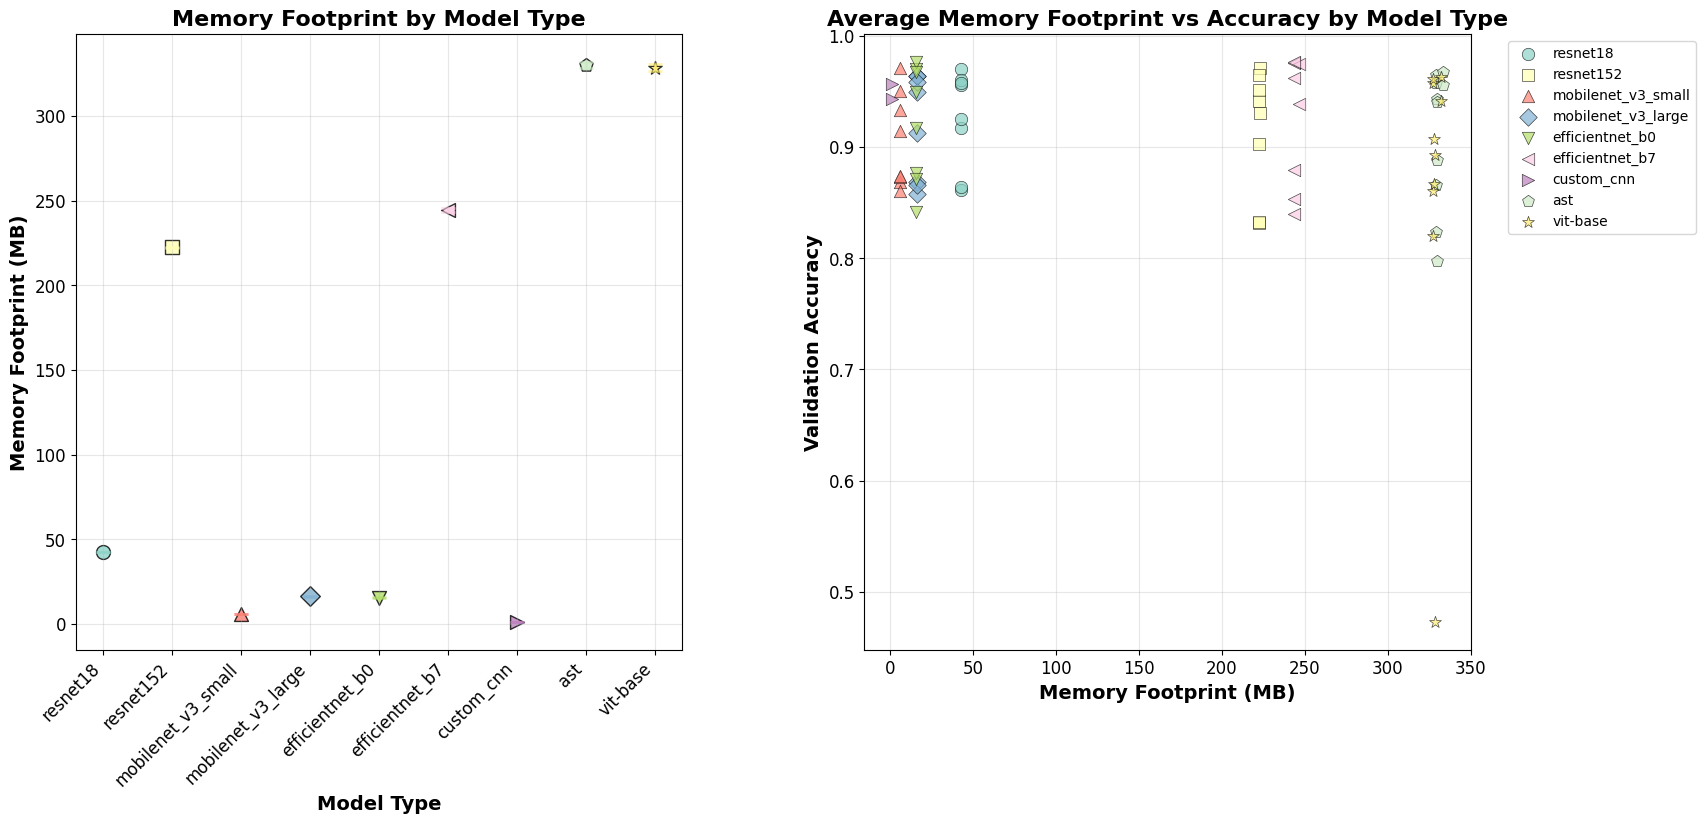

=== MEMORY FOOTPRINT STATISTICS ===

Memory Footprint by Model Type:
                      mean  median   std     min     max  count
model                                                          
ast                 330.02  329.29  1.81  328.88  333.40     10
vit-base            328.53  327.79  1.81  327.39  331.91     10
efficientnet_b7     244.36  243.63  1.36  243.63  246.56      8
resnet152           222.31  222.02  0.53  222.02  223.17      8
resnet18             42.69   42.67  0.03   42.67   42.74      8
mobilenet_v3_large   16.24   16.18  0.11   16.18   16.41      8
efficientnet_b0      15.53   15.44  0.18   15.44   15.83      8
mobilenet_v3_small    5.94    5.91  0.06    5.91    6.03      8
custom_cnn            1.12    1.12  0.00    1.12    1.12      2

Memory Footprint by Configuration Type:
               mean  median     std     min     max  count
config_type                                               
oft          332.65  332.65    0.86  331.91  333.40      4
ia3      

In [22]:
# Memory Footprint Analysis: Two scatter plots
plt.style.use('default')
fig = plt.figure(figsize=(18, 8))

# Create subplot layout: two plots side by side
gs = fig.add_gridspec(1, 2, wspace=0.3)

# Left subplot: Memory footprint by model type (one point per model with std dev)
ax1 = fig.add_subplot(gs[0, 0])

# Calculate mean and std dev for each model
model_types = plot_df['model'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(model_types)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
model_color_map = dict(zip(model_types, colors))
marker_map = dict(zip(model_types, markers[:len(model_types)]))

# Prepare data for scatter plot
x_positions = []
y_means = []
y_stds = []
model_labels = []

for i, model in enumerate(model_types):
    model_data = plot_df[plot_df['model'] == model]['memory_footprint_mb']
    if len(model_data) > 0:
        mean_val = model_data.mean()
        std_val = model_data.std()
        
        x_positions.append(i)
        y_means.append(mean_val)
        y_stds.append(std_val)
        model_labels.append(model)

# Create scatter plot with error bars using both colors and shapes
for i, (x, y_mean, y_std, model) in enumerate(zip(x_positions, y_means, y_stds, model_labels)):
    ax1.scatter(x, y_mean, color=model_color_map[model], alpha=0.8, s=100, 
               marker=marker_map[model], label=model, edgecolors='black', linewidth=1)
    # Add error bars for standard deviation
    ax1.errorbar(x, y_mean, yerr=y_std, color=model_color_map[model], 
                alpha=0.6, capsize=5, capthick=2, linewidth=2)

# Set x-axis labels and ticks
ax1.set_xticks(range(len(model_types)))
ax1.set_xticklabels(model_types, rotation=45, ha='right')

ax1.set_title('Memory Footprint by Model Type', fontsize=16, weight='bold')
ax1.set_xlabel('Model Type', fontsize=14, weight='bold')
ax1.set_ylabel('Memory Footprint (MB)', fontsize=14, weight='bold')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Right subplot: Memory footprint vs accuracy comparison (scatter plot)
ax2 = fig.add_subplot(gs[0, 1])

# Use the same color and marker mapping as the first subplot for consistency
for model in model_types:
    model_data = plot_df[plot_df['model'] == model]
    ax2.scatter(model_data['memory_footprint_mb'], model_data['accuracy'],
               color=model_color_map[model], alpha=0.7, s=80,
               marker=marker_map[model], label=model,  # Use same shapes and colors
               edgecolors='black', linewidth=0.5)

ax2.set_title('Average Memory Footprint vs Accuracy by Model Type', fontsize=16, weight='bold')
ax2.set_xlabel('Memory Footprint (MB)', fontsize=14, weight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=14, weight='bold')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Simple scatter plot without correlation line

plt.tight_layout()
plt.savefig('memory_footprint_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print memory footprint statistics
print("=== MEMORY FOOTPRINT STATISTICS ===")
print("\nMemory Footprint by Model Type:")
memory_stats = plot_df.groupby('model')['memory_footprint_mb'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
memory_stats = memory_stats.sort_values('mean', ascending=False)  # Sort by mean memory usage (highest first)
print(memory_stats)

print("\nMemory Footprint by Configuration Type:")
memory_by_config = plot_df.groupby('config_type')['memory_footprint_mb'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
memory_by_config = memory_by_config.sort_values('mean', ascending=False)
print(memory_by_config)

print(f"\nOverall Memory Statistics:")
print(f"Average memory footprint: {plot_df['memory_footprint_mb'].mean():.2f} MB")
print(f"Median memory footprint: {plot_df['memory_footprint_mb'].median():.2f} MB")
print(f"Memory footprint range: {plot_df['memory_footprint_mb'].min():.2f} - {plot_df['memory_footprint_mb'].max():.2f} MB")

# Memory vs Accuracy relationship can be observed visually in the scatter plot


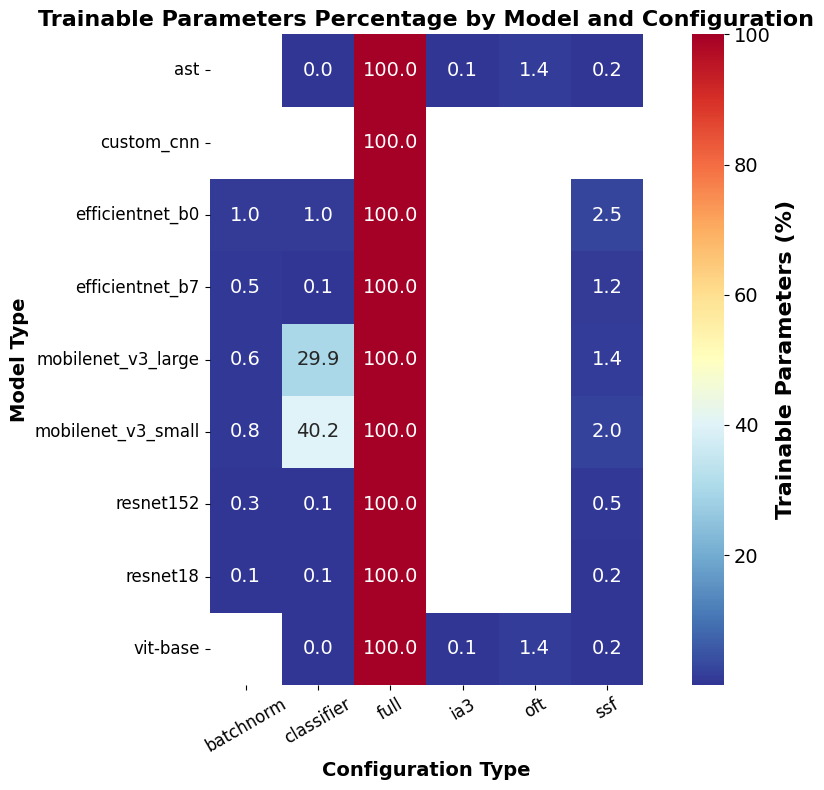

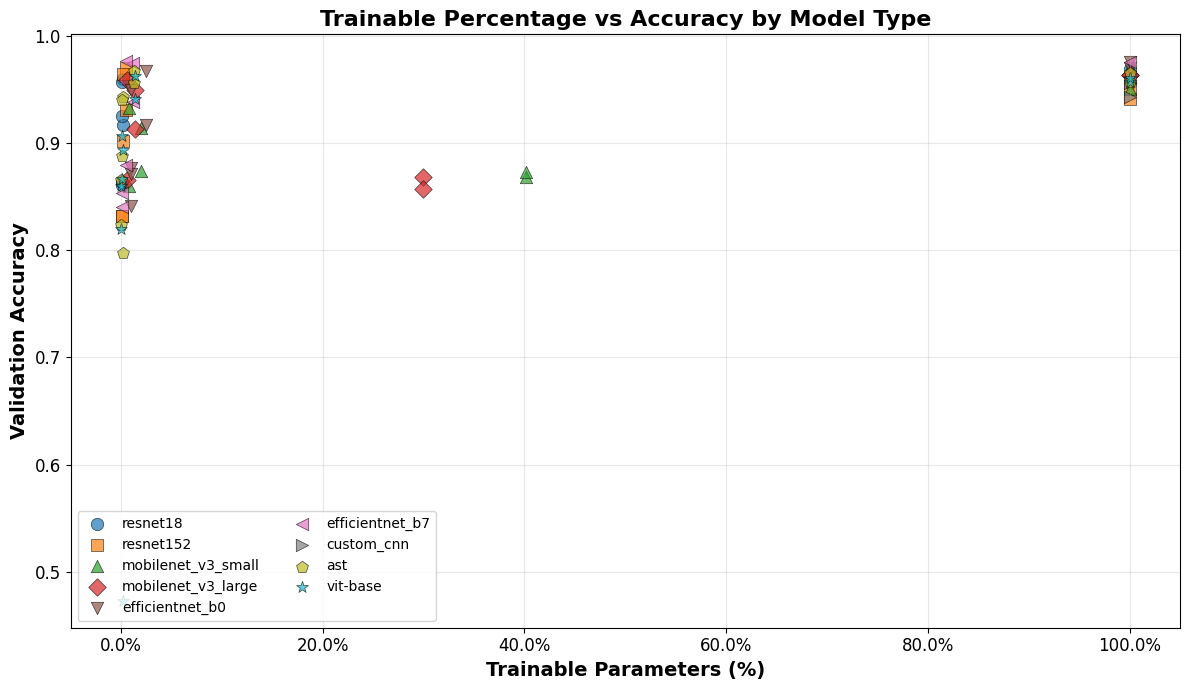

=== TRAINABLE PARAMETERS STATISTICS ===

Trainable Parameters by Model Type:
                          mean      median       std       min       max  \
model                                                                      
ast                 86512977.0  86321726.0  474125.0  86212639  87399358   
vit-base            86121733.0  85929278.0  473709.0  85822495  87007550   
efficientnet_b7     64057174.0  63865199.0  355470.0  63865199  64633101   
resnet152           58276750.0  58201055.0  140161.0  58201055  58503837   
resnet18            11190926.0  11186143.0    8857.0  11186143  11205277   
mobilenet_v3_large   4256850.0   4241455.0   28507.0   4241455   4303037   
efficientnet_b0      4072376.0   4046683.0   47575.0   4046683   4149457   
mobilenet_v3_small   1557370.0   1549343.0   14864.0   1549343   1581453   
custom_cnn            293887.0    293887.0       0.0    293887    293887   

                    count  
model                      
ast                    10  
vi

In [23]:
# Trainable Parameters Analysis: Separate Plots

# --- Heatmap: Trainable percentage by model and configuration type ---
plt.style.use('default')
fig1 = plt.figure(figsize=(10, 8))

# Create pivot table for trainable percentage
trainable_percentage_pivot = plot_df.pivot_table(
    values='trainable_percentage', 
    index='model', 
    columns='config_type', 
    aggfunc='mean'
)

# Create heatmap
ax1 = fig1.add_subplot(1, 1, 1)
sns.heatmap(
    trainable_percentage_pivot,
    annot=True,
    fmt='.1f',
    cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (red for high, blue for low)
    ax=ax1,
    cbar_kws={'label': 'Trainable Parameters (%)'},
    annot_kws={"size": 14},
    square=True
)

ax1.set_title('Trainable Parameters Percentage by Model and Configuration', fontsize=16, weight='bold')
ax1.set_xlabel('Configuration Type', fontsize=14, weight='bold')
ax1.set_ylabel('Model Type', fontsize=14, weight='bold')
ax1.tick_params(axis='x', labelsize=12, rotation=30)
ax1.tick_params(axis='y', labelsize=12, rotation=0)

# Make the colorbar label larger
cbar = ax1.collections[0].colorbar
cbar.set_label('Trainable Parameters (%)', fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('trainable_parameters_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Scatter Plot: Trainable Percentage vs Accuracy ---
fig2 = plt.figure(figsize=(12, 7))

ax2 = fig2.add_subplot(1, 1, 1)

# Create scatter plot with different colors and markers for each model type
model_types = plot_df['model'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(model_types)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
model_color_map = dict(zip(model_types, colors))
marker_map = dict(zip(model_types, markers[:len(model_types)]))

for model in model_types:
    model_data = plot_df[plot_df['model'] == model]
    ax2.scatter(model_data['trainable_percentage'], model_data['accuracy'],
               color=model_color_map[model], alpha=0.7, s=80,
               marker=marker_map[model], label=model,
               edgecolors='black', linewidth=0.5)

ax2.set_title('Trainable Percentage vs Accuracy by Model Type', fontsize=16, weight='bold')
ax2.set_xlabel('Trainable Parameters (%)', fontsize=14, weight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=14, weight='bold')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)

# Format x-axis to show percentage with one decimal
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

# Add legend
ax2.legend(bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize=10, ncol=2)

plt.tight_layout()
plt.savefig('trainable_percentage_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed trainable parameters statistics
print("=== TRAINABLE PARAMETERS STATISTICS ===")
print("\nTrainable Parameters by Model Type:")
trainable_stats = plot_df.groupby('model')['trainable_parameters'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
trainable_stats = trainable_stats.sort_values('mean', ascending=False)  # Sort by mean trainable params (highest first)
print(trainable_stats.round(0))

print("\nTrainable Percentage by Model Type:")
trainable_pct_stats = plot_df.groupby('model')['trainable_percentage'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
trainable_pct_stats = trainable_pct_stats.sort_values('mean', ascending=False)
print(trainable_pct_stats)

print("\nTrainable Parameters by Configuration Type:")
trainable_by_config = plot_df.groupby('config_type')['trainable_parameters'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
trainable_by_config = trainable_by_config.sort_values('mean', ascending=False)
print(trainable_by_config.round(0))

print("\nTrainable Percentage by Configuration Type:")
trainable_pct_by_config = plot_df.groupby('config_type')['trainable_percentage'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
trainable_pct_by_config = trainable_pct_by_config.sort_values('mean', ascending=False)
print(trainable_pct_by_config)

print(f"\nOverall Trainable Parameters Statistics:")
print(f"Average trainable parameters: {plot_df['trainable_parameters'].mean():.0f}")
print(f"Median trainable parameters: {plot_df['trainable_parameters'].median():.0f}")
print(f"Trainable parameters range: {plot_df['trainable_parameters'].min():.0f} - {plot_df['trainable_parameters'].max():.0f}")


In [24]:
# TODO training times in latex table,  
training_times_df = plot_df[['model', 'trainable_percentage', 'config_type']]
memory_df = plot_df[['model', 'memory_footprint_mb', 'config_type']]
time_df = plot_df[['model', 'runtime_minutes', 'config_type']]
plot_df

,model,accuracy,std_dev,config_type,aug_level,model_config,runtime,runtime_hhmmss,total_parameters,trainable_parameters,trainable_percentage,memory_footprint_mb,runtime_minutes,runtime_hours,efficiency
0,resnet18,0.956129,0.012173,full,0,resnet18-full,625.574690,0 days 00:10:25.574690,11186143,11186143,100.000000,42.671749,10.426245,0.173771,0.091704
1,resnet18,0.969677,0.006797,full,3,resnet18-full,1958.920682,0 days 00:32:38.920682,11186143,11186143,100.000000,42.671749,32.648678,0.544145,0.029700
2,resnet18,0.861290,0.023440,classifier,0,resnet18-classifier,694.711208,0 days 00:11:34.711208,11186143,11186143,0.142167,42.671749,11.578520,0.192975,0.074387
3,resnet18,0.863871,0.020821,classifier,3,resnet18-classifier,1774.837934,0 days 00:29:34.837934,11186143,11186143,0.142167,42.671749,29.580632,0.493011,0.029204
4,resnet18,0.916774,0.014412,ssf,0,resnet18-ssf,832.591925,0 days 00:13:52.591925,11205277,11205277,0.170759,42.744740,13.876532,0.231276,0.066067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,vit-base,0.893226,0.015980,ssf,3,vit-base-ssf,4357.561045,0 days 01:12:37.561045,86026845,86026845,0.237542,328.166370,72.626017,1.210434,0.012299
66,vit-base,0.866452,0.014691,ia3,0,vit-base-ia3,1464.925162,0 days 00:24:24.925162,85929278,85929278,0.124268,327.794182,24.415419,0.406924,0.035488
67,vit-base,0.906774,0.011604,ia3,3,vit-base-ia3,4175.178238,0 days 01:09:35.178238,85929278,85929278,0.124268,327.794182,69.586304,1.159772,0.013031
68,vit-base,0.941290,0.008632,oft,0,vit-base-oft,8665.918723,0 days 02:24:25.918723,87007550,87007550,1.362014,331.907463,144.431979,2.407200,0.006517


In [ ]:
# here 


In [25]:
with pd.option_context('display.max_rows', None):
    display(training_times_df)

,model,trainable_percentage,config_type
0,resnet18,100.000000,full
1,resnet18,100.000000,full
2,resnet18,0.142167,classifier
3,resnet18,0.142167,classifier
4,resnet18,0.170759,ssf
5,resnet18,0.170759,ssf
6,resnet18,0.085820,batchnorm
7,resnet18,0.085820,batchnorm
8,resnet152,100.000000,full
9,resnet152,100.000000,full


In [26]:
with pd.option_context('display.max_rows', None):
    display(memory_df)

,model,memory_footprint_mb,config_type
0,resnet18,42.671749,full
1,resnet18,42.671749,full
2,resnet18,42.671749,classifier
3,resnet18,42.671749,classifier
4,resnet18,42.744740,ssf
5,resnet18,42.744740,ssf
6,resnet18,42.671749,batchnorm
7,resnet18,42.671749,batchnorm
8,resnet152,222.019405,full
9,resnet152,222.019405,full


In [27]:
with pd.option_context('display.max_rows', None):
    display(time_df)

,model,runtime_minutes,config_type
0,resnet18,10.426245,full
1,resnet18,32.648678,full
2,resnet18,11.578520,classifier
3,resnet18,29.580632,classifier
4,resnet18,13.876532,ssf
5,resnet18,40.117848,ssf
6,resnet18,13.143290,batchnorm
7,resnet18,34.527690,batchnorm
8,resnet152,29.727162,full
9,resnet152,108.750324,full
